In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

from datetime import *

# III. Exploratory Analysis

In [2]:
loans_df = pd.read_csv('Loans_Data.csv', delimiter="\t")
borrowers_df = pd.read_csv('Borrowers_Data.csv', delimiter="\t")

loans_df['StartDate']= pd.to_datetime(loans_df['StartDate'], dayfirst=True)
loans_df['MaturityDate']= pd.to_datetime(loans_df['MaturityDate'], dayfirst=True)

## Information summary of loan and borrower dataframes

## Summary Statistics from loan and borrower data

In [3]:
loans_df.describe().iloc[[1,2,3,5,7], 2:7]

,Amount,grossrate,PrincipalOutstanding,term,DaysEarly
mean,6500.817453,5.169152,1526.636806,43.598740,531.018072
std,5376.540973,0.937821,3059.455919,16.245985,544.845443
min,38.000000,3.050000,0.000000,2.000000,-782.000000
50%,5040.360000,5.001100,0.000000,48.000000,402.000000
max,30957.490000,6.610000,29499.410000,60.000000,1826.000000


In [4]:
borrowers_df.describe().iloc[[1,2,3,5,7], 1:]

,total_loans,total_borrowed,balance,active,settled,defaults,delinquencies
mean,1.057255,6873.019671,1614.043907,0.294038,0.652937,0.100243,0.007701
std,0.265076,5765.894102,3136.958143,0.462355,0.561638,0.304400,0.088852
min,1.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,5250.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,7.000000,75035.200000,29499.410000,3.000000,7.000000,3.000000,2.000000


In [5]:
print(borrowers_df.groupby('total_loans')['BorrowerID'].count())
print(borrowers_df.groupby('defaults')['BorrowerID'].count())

total_loans
1    30083
2     1420
3      153
4       22
5        4
7        1
Name: BorrowerID, dtype: int64
defaults
0    28545
1     3101
2       36
3        1
Name: BorrowerID, dtype: int64


## Plotting the distribution of loan amounts

Plots: Total amount issued to each borrower, total amounts lent per loan (with loan status), total amounts per loan (per year)

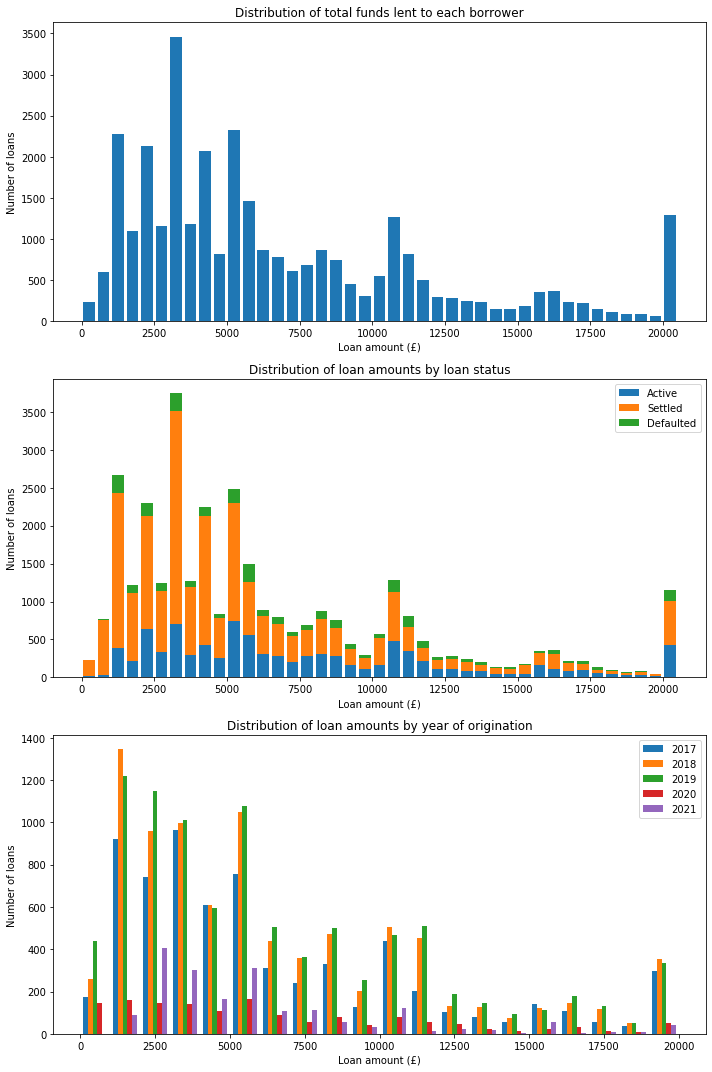

In [6]:
fig, axes = plt.subplots(3,1, figsize=(10,15))

bins = np.arange(0, 21000, 500)

axes[0].hist(np.clip(borrowers_df['total_borrowed'], bins[0], bins[-1]),
             bins=bins,
             rwidth=0.8)
axes[0].set_title("Distribution of total funds lent to each borrower")
axes[0].set_ylabel("Number of loans")
axes[0].set_xlabel("Loan amount (£)")

axes[1].hist([np.clip(loans_df.loc[loans_df['LoanStatus']=="Active"]['Amount'], bins[0], bins[-1]),
              np.clip(loans_df.loc[loans_df['LoanStatus']=="Settled"]['Amount'], bins[0], bins[-1]),
              np.clip(loans_df.loc[loans_df['LoanStatus']=="Defaulted"]['Amount'], bins[0], bins[-1])], 
            bins=bins, rwidth=0.8, stacked=True, label=(['Active', 'Settled', "Defaulted"]))
axes[1].set_title("Distribution of loan amounts by loan status")
axes[1].legend()
axes[1].set_ylabel("Number of loans")
axes[1].set_xlabel("Loan amount (£)")

bins = np.arange(0, 21000, 1000)

axes[2].hist([np.clip(loans_df.loc[loans_df['StartDate'].dt.year==2017]['Amount'], bins[0], bins[-1]),
              np.clip(loans_df.loc[loans_df['StartDate'].dt.year==2018]['Amount'], bins[0], bins[-1]),
              np.clip(loans_df.loc[loans_df['StartDate'].dt.year==2019]['Amount'], bins[0], bins[-1]),
              np.clip(loans_df.loc[loans_df['StartDate'].dt.year==2020]['Amount'], bins[0], bins[-1]),
              np.clip(loans_df.loc[loans_df['StartDate'].dt.year==2021]['Amount'], bins[0], bins[-1])],
             bins=bins, rwidth=0.8, stacked=False, label=(['2017','2018','2019','2020','2021']))
axes[2].set_title("Distribution of loan amounts by year of origination")
axes[2].legend()
axes[2].set_ylabel("Number of loans")
axes[2].set_xlabel("Loan amount (£)")

fig.tight_layout()
plt.show()

## Finding number of defaulted loans that matured on their expiry date

In [7]:
loans_df['MaturityYear'] = loans_df['MaturityDate'].dt.year
loans_df['StartYear'] = loans_df['StartDate'].dt.year

defaults_df = loans_df.loc[loans_df['LoanStatus']=="Defaulted"]

len(defaults_df.loc[defaults_df['DaysEarly'] == 0])

9

## Create a dataframe for defaulted loans with aggregate loan data

In [8]:
default_freq = borrowers_df.groupby('defaults').agg(frequency = ('BorrowerID','count'))
default_grouped = defaults_df.groupby(['default_reason','MaturityYear']).agg(frequency = ("LoanID",'count'),
                                                         total_outstanding = ("PrincipalOutstanding", 'sum'),
                                                         mean_outstanding = ("PrincipalOutstanding", 'mean'),
                                                         mean_apr = ("grossrate", "mean")).reset_index()

## Visualising the proportion of default reasons per year

C:\Users\arsia\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


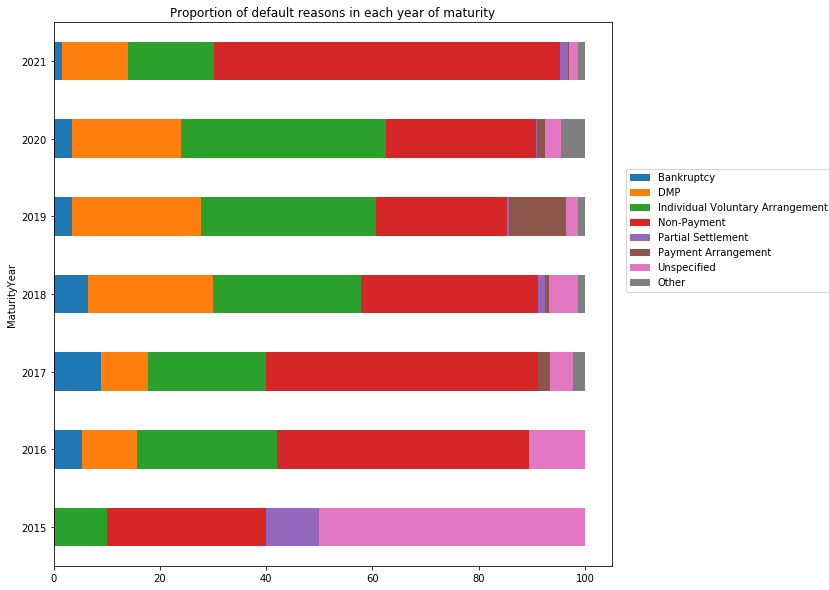

In [9]:
year_samples = np.sort(default_grouped['MaturityYear'].unique())

for year in year_samples:
    if year > 2021:
        break
    else:
        year_defs = default_grouped.loc[default_grouped['MaturityYear']==year]
        year_total_defs = year_defs['frequency'].sum()
        default_grouped.loc[default_grouped['MaturityYear']==year, '% of defaults'] = 100*default_grouped['frequency']/year_total_defs

default_matrix = default_grouped.loc[(default_grouped['MaturityYear']<2022)].pivot("MaturityYear","default_reason","% of defaults")

top_defaults = default_matrix[['Bankruptcy',
                               'DMP',
                               'Individual Voluntary Arrangement (IVA)',
                               'Non-Payment',
                               'Partial Settlement',
                               'Payment Arrangement',
                               'Unspecified']]
top_defaults['Other'] = default_matrix[['DAS','Debt Relief Order (DRO)','Fraud','Protected Trust Deed']].sum(axis=1)

fig, ax = plt.subplots()

top_defaults.plot(kind="barh", stacked=True, ax=ax, figsize=(10,10), legend=False, sharex=False, title="Proportion of default reasons in each year of maturity" )
fig.legend(loc="right", bbox_to_anchor=(1.2, 0.5))
ax.set_ylabel = "Year of Maturity"
ax.set_xlabel = "% of Defaults"
plt.show()

#plt.bar(top_defaults, stacked=True, figsize=(15,10))

## Plotting distribution of defaults per loan APR in specific years

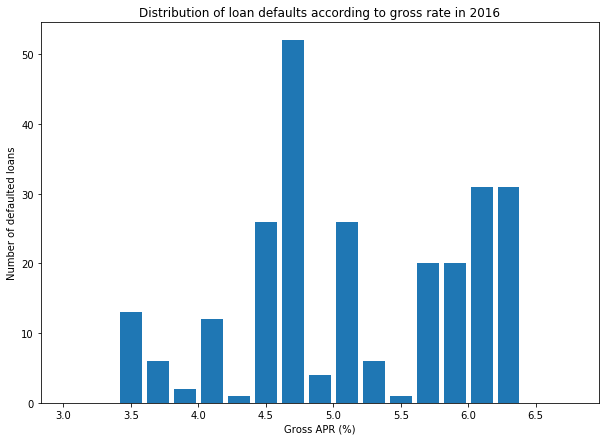

In [10]:
fig, axes = plt.subplots(figsize=(10,7))

bins = np.arange(3, 7, 0.2)

startyear = 2016
axes.hist(np.clip(loans_df.loc[(loans_df['StartDate'].dt.year == startyear) & (loans_df['LoanStatus']=="Defaulted")]['grossrate'], bins[0], bins[-1]),
             bins=bins,
             #density=True,
             rwidth=0.8)
axes.set_ylabel("Number of defaulted loans")
axes.set_xlabel("Gross APR (%)")
axes.set_title(f"Distribution of loan defaults according to gross rate in {startyear}")
plt.show()

## Visualising the distribution of outstanding balances for active and defaulted loans

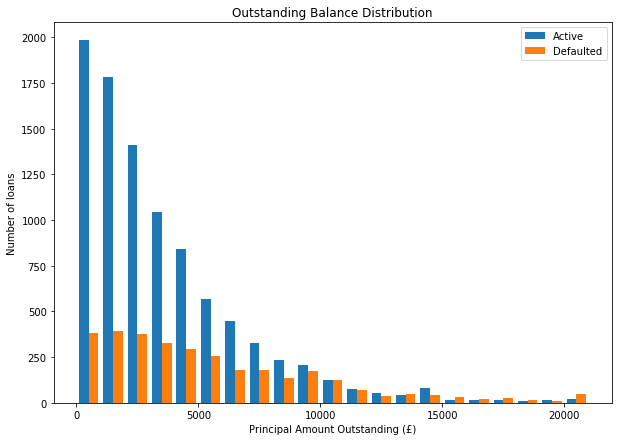

In [11]:
fig, ax = plt.subplots(figsize=(10,7))

bins = np.arange(0, 21500, 1000)

ax.hist([np.clip(loans_df.loc[loans_df['LoanStatus']=="Active"]['PrincipalOutstanding'], bins[0], bins[-1]),
         np.clip(loans_df.loc[loans_df['LoanStatus']=="Defaulted"]['PrincipalOutstanding'], bins[0], bins[-1])],
        log=False, bins = bins, rwidth=0.8, label=['Active','Defaulted'])
ax.set_title("Outstanding Balance Distribution")
ax.set_ylabel("Number of loans")
ax.set_xlabel("Principal Amount Outstanding (£)")
ax.legend()
plt.show()

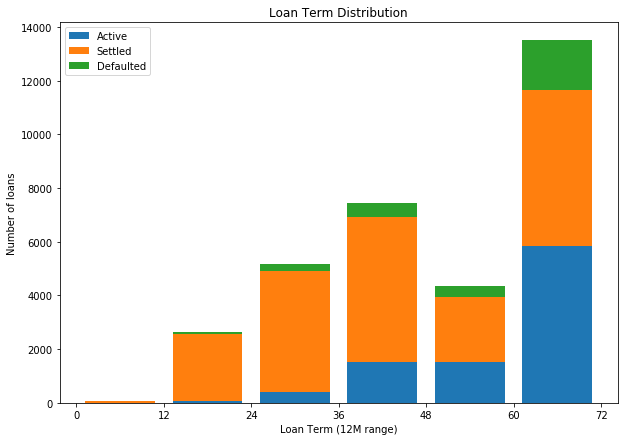

In [12]:
fig, ax = plt.subplots(figsize=(10,7))

ax.hist([loans_df.loc[loans_df['LoanStatus']=="Active"]['term'],
         loans_df.loc[loans_df['LoanStatus']=="Settled"]['term'],
         loans_df.loc[loans_df['LoanStatus']=="Defaulted"]['term']],
        log=False, bins=6, rwidth=0.8, range=(0,72), stacked=True, label=['Active','Settled','Defaulted'])
ax.legend()
ax.set_xticks(np.arange(0,73,12))
ax.set_xlabel("Loan Term (12M range)")
ax.set_ylabel("Number of loans")
ax.set_title("Loan Term Distribution")

plt.show()

## Comparison of lending operations and defaults through time (since 2019)

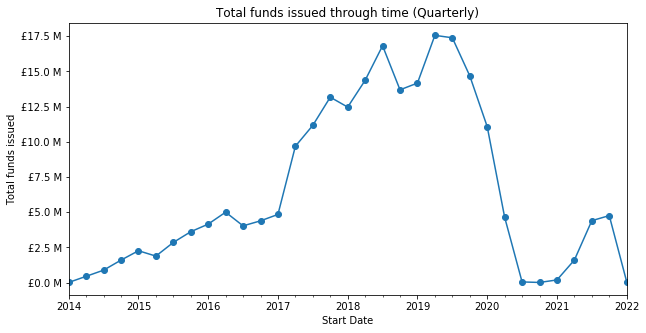

In [13]:
loans_ts = loans_df.groupby('StartDate').agg(number_issued_loans=('LoanID','count'),
                                  total_amount_issued=('Amount', 'sum'),
                                  mean_loan_apr=('grossrate', 'mean'),
                                  number_defaulted = ('LoanStatus', lambda x: x[x.str.contains('Defaulted')].count()))

loans_ts['default_rate'] = 100*loans_ts['number_defaulted']/loans_ts['number_issued_loans']

ax = loans_ts['total_amount_issued'].resample('3M').sum().plot(style="-o", figsize=(10,5))

ax.set(xlabel="Start Date", ylabel="Total funds issued", title="Total funds issued through time (Quarterly)")

y_scale = [n for n in np.arange(0, 18000000, 2500000)]

plt.yticks(y_scale, [f"£{ytick/1000000} M" for ytick in y_scale])

plt.show()

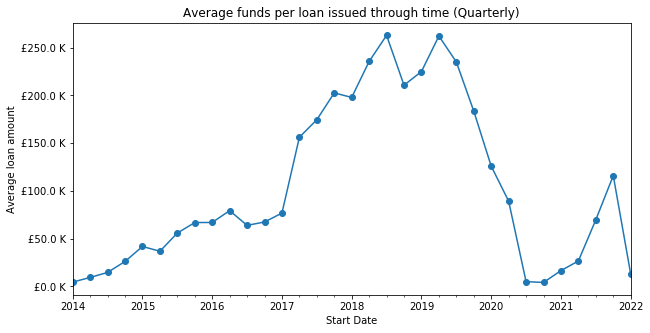

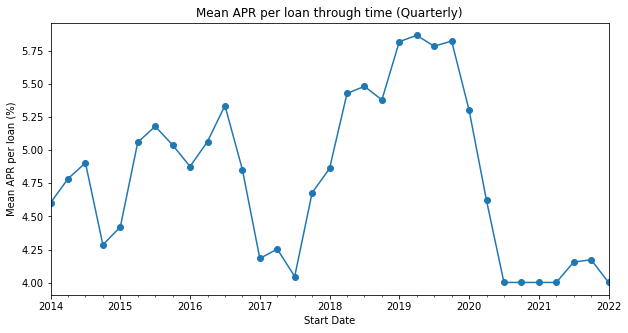

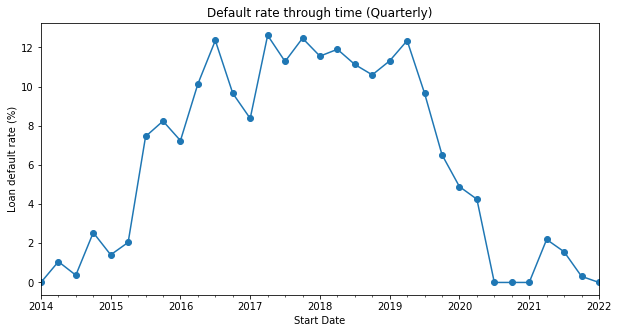

In [14]:
loans_qrt_ts = loans_ts[['mean_loan_apr','default_rate','total_amount_issued']].resample('3M').mean()

y_scale = [num for num in np.arange(0,260000, 50000)]

ax1=loans_qrt_ts['total_amount_issued'].plot(style="-o", figsize=(10,5))
ax1.set(xlabel="Start Date",
        ylabel="Average loan amount",
        title="Average funds per loan issued through time (Quarterly)")

plt.yticks(y_scale, [f"£{ytick/1000} K" for ytick in y_scale])
plt.show()

ax2=loans_qrt_ts['mean_loan_apr'].plot(style="-o", figsize=(10,5))
ax2.set(xlabel="Start Date", ylabel="Mean APR per loan (%)", title="Mean APR per loan through time (Quarterly)")
plt.show()

ax3=loans_qrt_ts['default_rate'].plot(style="-o", figsize=(10,5))
ax3.set(xlabel="Start Date", ylabel="Loan default rate (%)", title="Default rate through time (Quarterly)")
plt.show()

### Calculating correlations between average issued funds and gross APR to default rates (with and without COVID data)

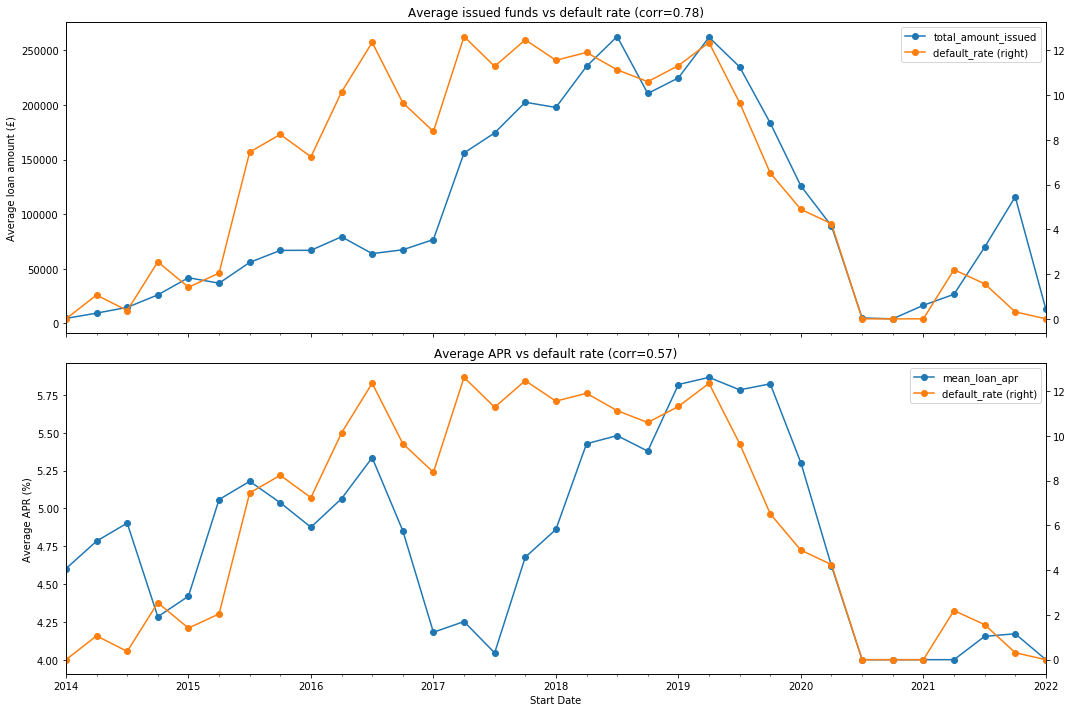

In [15]:
corr_def_amount = loans_qrt_ts['default_rate'].corr(loans_qrt_ts['total_amount_issued'])
corr_def_apr = loans_qrt_ts['default_rate'].corr(loans_qrt_ts['mean_loan_apr'])

fig2,axes = plt.subplots(2,1, figsize=(15,10))
loans_qrt_ts[['total_amount_issued','default_rate']].plot(style="-o",
                                                          ax=axes[0],
                                                          secondary_y='default_rate',
                                                          label=["Average funds","Default Rate"],
                                                          title=f"Average issued funds vs default rate (corr={corr_def_amount:.2f})")
y_scale = [num for num in np.arange(0,260000, 50000)]
axes[0].set(xlabel="Start Date",
        ylabel="Average loan amount (£)")

loans_qrt_ts[['mean_loan_apr','default_rate']].plot(style="-o",
                                                    ax=axes[1],
                                                    secondary_y='default_rate',
                                                    title=f"Average APR vs default rate (corr={corr_def_apr:.2f})")
axes[1].set(xlabel="Start Date",
        ylabel="Average APR (%)")
fig2.tight_layout()

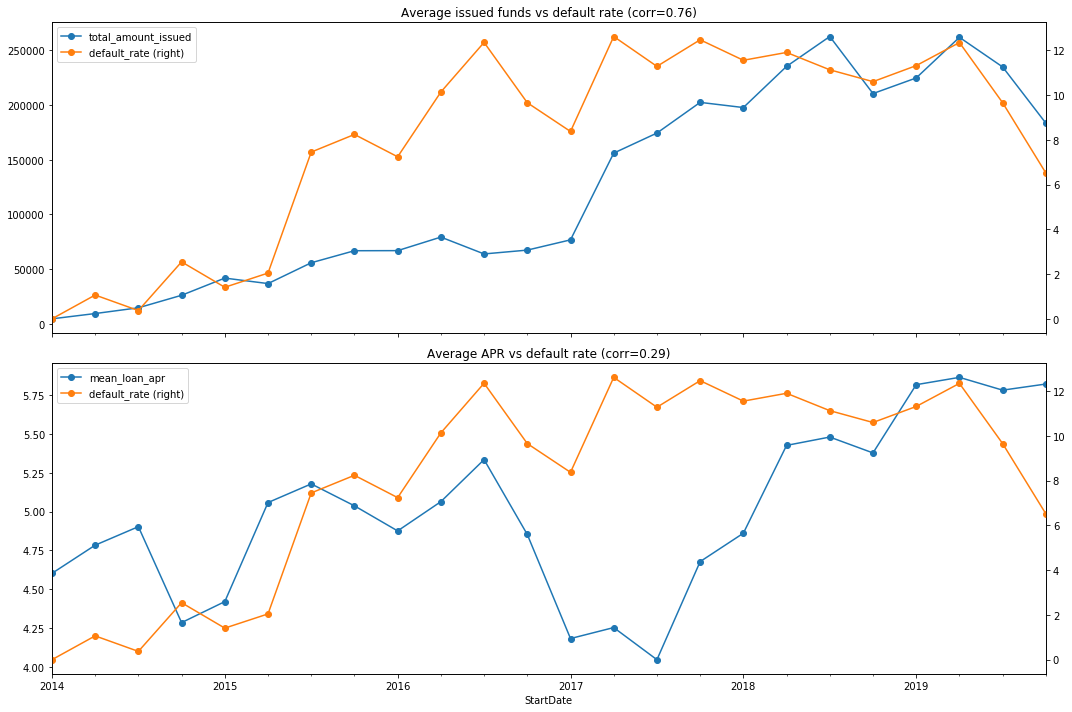

In [16]:
pre_cov_loans_ts = loans_qrt_ts.loc['2014-01-31':'2019-10-31']

corr_def_amount = pre_cov_loans_ts['default_rate'].corr(pre_cov_loans_ts['total_amount_issued'])
corr_def_apr = pre_cov_loans_ts['default_rate'].corr(pre_cov_loans_ts['mean_loan_apr'])

fig2,axes = plt.subplots(2,1, figsize=(15,10))
pre_cov_loans_ts[['total_amount_issued','default_rate']].plot(style="-o",
                                                          ax=axes[0],
                                                          secondary_y='default_rate',
                                                          title=f"Average issued funds vs default rate (corr={corr_def_amount:.2f})")
y_scale = [num for num in np.arange(0,260000, 50000)]
axes[0].set(xlabel="Start Date",
        label="Average loan amount")

#plt.yticks(y_scale, [f"£{ytick/1000} K" for ytick in y_scale])

pre_cov_loans_ts[['mean_loan_apr','default_rate']].plot(style="-o",
                                                    ax=axes[1],
                                                    secondary_y='default_rate',
                                                    title=f"Average APR vs default rate (corr={corr_def_apr:.2f})")
fig2.tight_layout()